### Импорт библиотек, настройка



In [1]:
import torch
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import glob
from glob import glob

c:\Users\minik\anaconda3\envs\PyTorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.2.2
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
**********
CUDNN version: 8801
Available GPU devices: 1
Device Name: NVIDIA GeForce GTX 1650 Ti


### Create DataSet, Preproccesing, Augmentation, DataLoader


In [37]:
# Пути данных
TRAIN_DATA = "C:\\Users\\minik\\Desktop\\datasets\\DS_Pathology_aug\\train"
TRAIN_AUG = "C:\\Users\\minik\\Desktop\\datasets\\DS_Pathology_aug\\train_aug"
VAL_DATA = "C:\\Users\\minik\\Desktop\\datasets\\DS_Pathology_aug\\val"
TEST_DATA = "C:\\Users\\minik\\Desktop\\datasets\\DS_Pathology_aug\\test"


In [102]:
transform_set = t = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.GaussNoise(),
               A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5), p=0.4)])

import torch.nn.functional as F


#Создаем класс для создания датасета, в котором используем аугментацию
#данных с помощью библиотеки Albumentation
class CustomDataset(Dataset):
    def __init__(self, img_path, msk_path, transform_set = transform_set):
        self.images_paths = os.path.join(img_path, 'images')
        self.masks_paths = os.path.join(msk_path, 'masks\\Tubulitis')
        self.image_filenames = sorted(list(set(os.listdir(self.masks_paths)) - {'desktop.ini'}))
        self.transform_set = transform_set


    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        #print(image_name)
        image_path = os.path.join(self.images_paths, image_name)
        #print(image_path)
        mask_path = os.path.join(self.masks_paths, image_name)
        #print(mask_path)

        #image = Image.open(image_path).convert("RGB")
        #mask = Image.open(mask_path).convert("L")


        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512,512))
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (512,512))

        mask = np.where(mask<127, 0, 1).astype(np.int16)
        #mask = torch.tensor(mask, dtype=torch.long)
        #mask = F.one_hot(mask, num_classes=2)

        # Normalize images and masks
        if self.transform_set!=None:
            aug = self.transform_set(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
            
            #mask = mask.permute(2,0,1)

        norm = A.Normalize()(image = image)#, mask = np.expand_dims(mask, 0))

        return norm['image'].transpose(2, 0, 1),  np.expand_dims(mask, 0)

In [103]:
# Создаем датасеты для обучения
from torch.utils.data import ConcatDataset

orig_train_dataset = CustomDataset(
    img_path=TRAIN_DATA,
    msk_path=TRAIN_DATA,
    transform_set=transform_set
)

aug_train_dataset = CustomDataset(
    img_path=TRAIN_AUG,
    msk_path=TRAIN_AUG,
    transform_set=transform_set
)

train_dataset = ConcatDataset([orig_train_dataset,aug_train_dataset])


val_dataset = CustomDataset(
    img_path=VAL_DATA,
    msk_path=VAL_DATA,
    transform_set=None
)
test_dataset = CustomDataset(
    img_path=TEST_DATA,
    msk_path=TEST_DATA,
    transform_set=None
)

In [104]:
train_dataset[25]

(array([[[2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
          2.2489083],
         [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
          2.2489083],
         [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
          2.2489083],
         ...,
         [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
          2.2489083],
         [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
          2.2489083],
         [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
          2.2489083]],
 
        [[2.4285712, 2.4285712, 2.2009802, ..., 2.4285712, 2.4285712,
          2.4285712],
         [2.4110644, 2.4285712, 2.1659663, ..., 2.4285712, 2.4285712,
          2.4285712],
         [2.4110644, 2.2184873, 2.2710083, ..., 2.4285712, 2.4285712,
          2.4285712],
         ...,
         [1.8333333, 2.3760502, 1.9733893, ..., 2.4285712, 2.4285712,
          2.4285712],
         [2.4285712, 2.4285712, 2.1659663, ..., 2

In [105]:
np.unique(train_dataset[56][1])

array([0, 1], dtype=int16)

In [106]:
# Создаем генераторы изображений для последовательной подачи в модель
# для тренировки, чтобы избежать ошибок с оперативной памятью и улучшить
# скорость обучения

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)


val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)


test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)


In [107]:
img, lab = next(iter(train_dataloader))
print(img.shape)
print(lab.shape)


torch.Size([2, 3, 512, 512])
torch.Size([2, 1, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


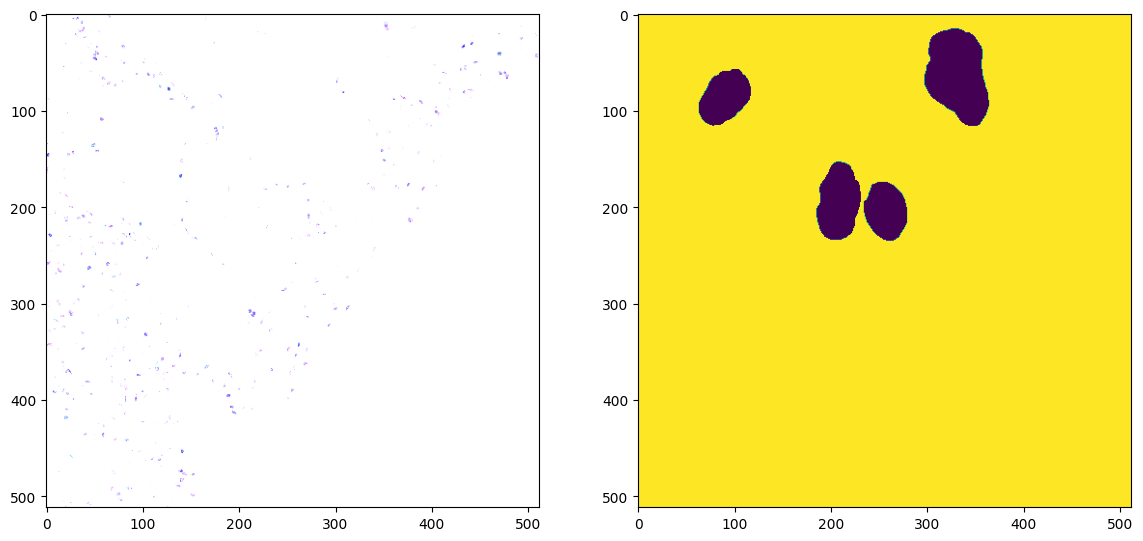

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


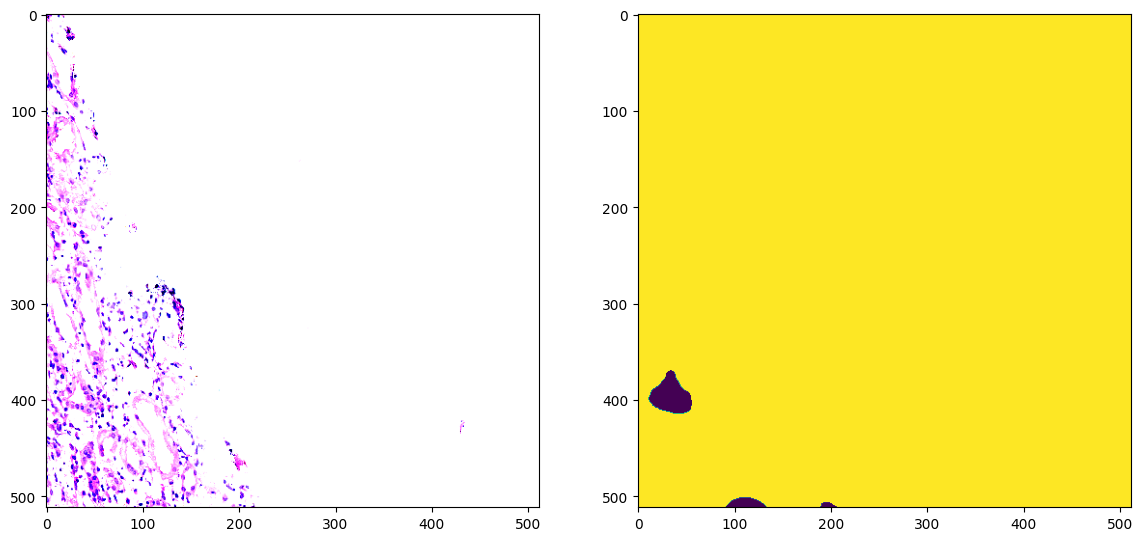

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


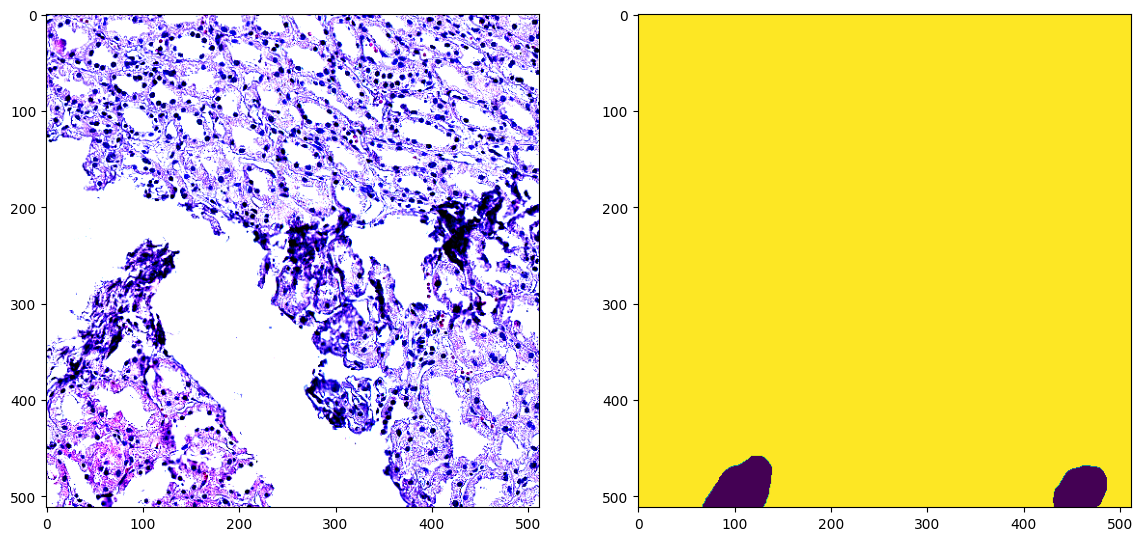

In [108]:
# lets look at some samples
image, mask = train_dataset[0]

plt.figure(figsize = (14, 10))
plt.subplot(1,2,1)
plt.imshow(np.array(image).transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(np.array(mask).squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

image, mask = val_dataset[0]

plt.figure(figsize = (14, 10))
plt.subplot(1,2,1)
plt.imshow(np.array(image).transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(np.array(mask).squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

image, mask = test_dataset[0]

plt.figure(figsize = (14, 10))
plt.subplot(1,2,1)
plt.imshow(np.array(image).transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(np.array(mask).squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

### С этого момента неообходимо выбрать Архитектуру нейросети и произвести ее настройку


Семантическая бинарная сегментация

In [109]:
#!pip install -U segmentation-models-pytorch
#!pip install pytorch-lightning==1.9.3
import segmentation_models_pytorch as smp
import pytorch_lightning as pl


In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [111]:
from tabulate import tabulate
from tqdm import tqdm
from collections import OrderedDict

class DroneModel(pl.LightningModule):
    def __init__(self, model, optimizer, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        
    def forward(self, x):
        return self.model(x)
    
    def shared_step(self, batch, stage):
        image, mask = batch
        out = self.forward(image)
        loss = self.criterion(out, mask.long())
        tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(out, 1).unsqueeze(1), mask.long(), mode='multiclass', num_classes = 2)
        recall =smp.metrics.recall(tp, fp, fn, tn, reduction="macro-imagewise")
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise")
        self.log(f"{stage}_IoU", iou, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_Recall", recall, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_loss", loss) 
        return {"loss": loss, "iou": iou}
        
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")     

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")
    
    def configure_optimizers(self):
        return self.optimizer

In [112]:
arch = 'unetplusplus'
enc_name = 'vgg16'
classes = 2

model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
criterion = smp.losses.DiceLoss(mode='multiclass', from_logits=True).to(device)
cbs = pl.callbacks.ModelCheckpoint(dirpath = f'C:\\Users\\minik\\Desktop\\Project\\Unet\\checkpoints\\checkpoints_unet\\checkpoints_{arch}',
                                   filename = arch, 
                                   verbose = True, 
                                   monitor = 'valid_loss', 
                                   mode = 'min')

In [ ]:
pl_model = DroneModel(model, optimizer, criterion)
trainer = pl.Trainer(max_epochs=20, auto_lr_find=True, callbacks=cbs, gpus=1)
trainer.fit(pl_model, train_dataloader, val_dataloader)

### TESTING

In [17]:
PATH_TO_SAVE = 'C:\\Users\\minik\\Desktop\\Project\\Unet\\PyTorch_Lighting\\Unet_tubulitis.pth'
torch.save(model.state_dict(), PATH_TO_SAVE)

In [18]:
model = torch.load('C:\\Users\\minik\\Desktop\\Project\\Unet\\PyTorch_Lighting\\Unet_tubulitis.pth')

In [19]:
cbs.best_model_path = "C:\\Users\\minik\\Desktop\\Project\\Unet\\checkpoints\\checkpoints_unet\\checkpoints_unet\\unet.ckpt"

In [20]:
model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

state_dict = torch.load(cbs.best_model_path)['state_dict']
pl_state_dict = OrderedDict([(key[6:], state_dict[key]) for key in state_dict.keys()])

model.load_state_dict(pl_state_dict)
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [24]:
## TESTING
with torch.no_grad(): 
    
    outputs = []
    test_loss = 0.0
    iou = 0

    for image, mask in tqdm(test_dataloader):       

        image = image.to(device); mask = mask.to(device)
        output = model(image).to(device)
        tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(output, 1).unsqueeze(1), mask.long(), mode='multiclass', num_classes = 2)
        outputs.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
        loss = criterion(output, mask.long()) 
        test_loss += loss.item() 
    
    tp = torch.cat([x["tp"] for x in outputs])
    fp = torch.cat([x["fp"] for x in outputs])
    fn = torch.cat([x["fn"] for x in outputs])
    tn = torch.cat([x["tn"] for x in outputs])
    
    print(f'Test Loss: {test_loss / len(test_dataloader)}')
    print('IoU:', smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").item())

100%|██████████| 56/56 [00:15<00:00,  3.59it/s]

Test Loss: 0.4859888239630631
IoU: 0.8540928959846497


In [ ]:
metrics = np.round(torch.stack([torch.mean(smp.metrics.recall(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.accuracy(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.false_positive_rate(tp, fp, fn, tn, reduction=None), 0),
                                1 - torch.mean(smp.metrics.recall(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.precision(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.iou_score(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.f1_score(tp, fp, fn, tn, reduction=None), 0),

                                ]).cpu().numpy(), 3)

info = {'Recall': metrics[0],
        'Accuracy':metrics[1],
        'Precision': metrics[4],
        'IoU': metrics[5],
        'F1-Score': metrics[6]
        }

table = tabulate(info, headers='keys', tablefmt='fancy_grid')
print(table)

with open(f'{arch}.txt', 'w') as f:
    f.write(table)

[0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]
[0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]


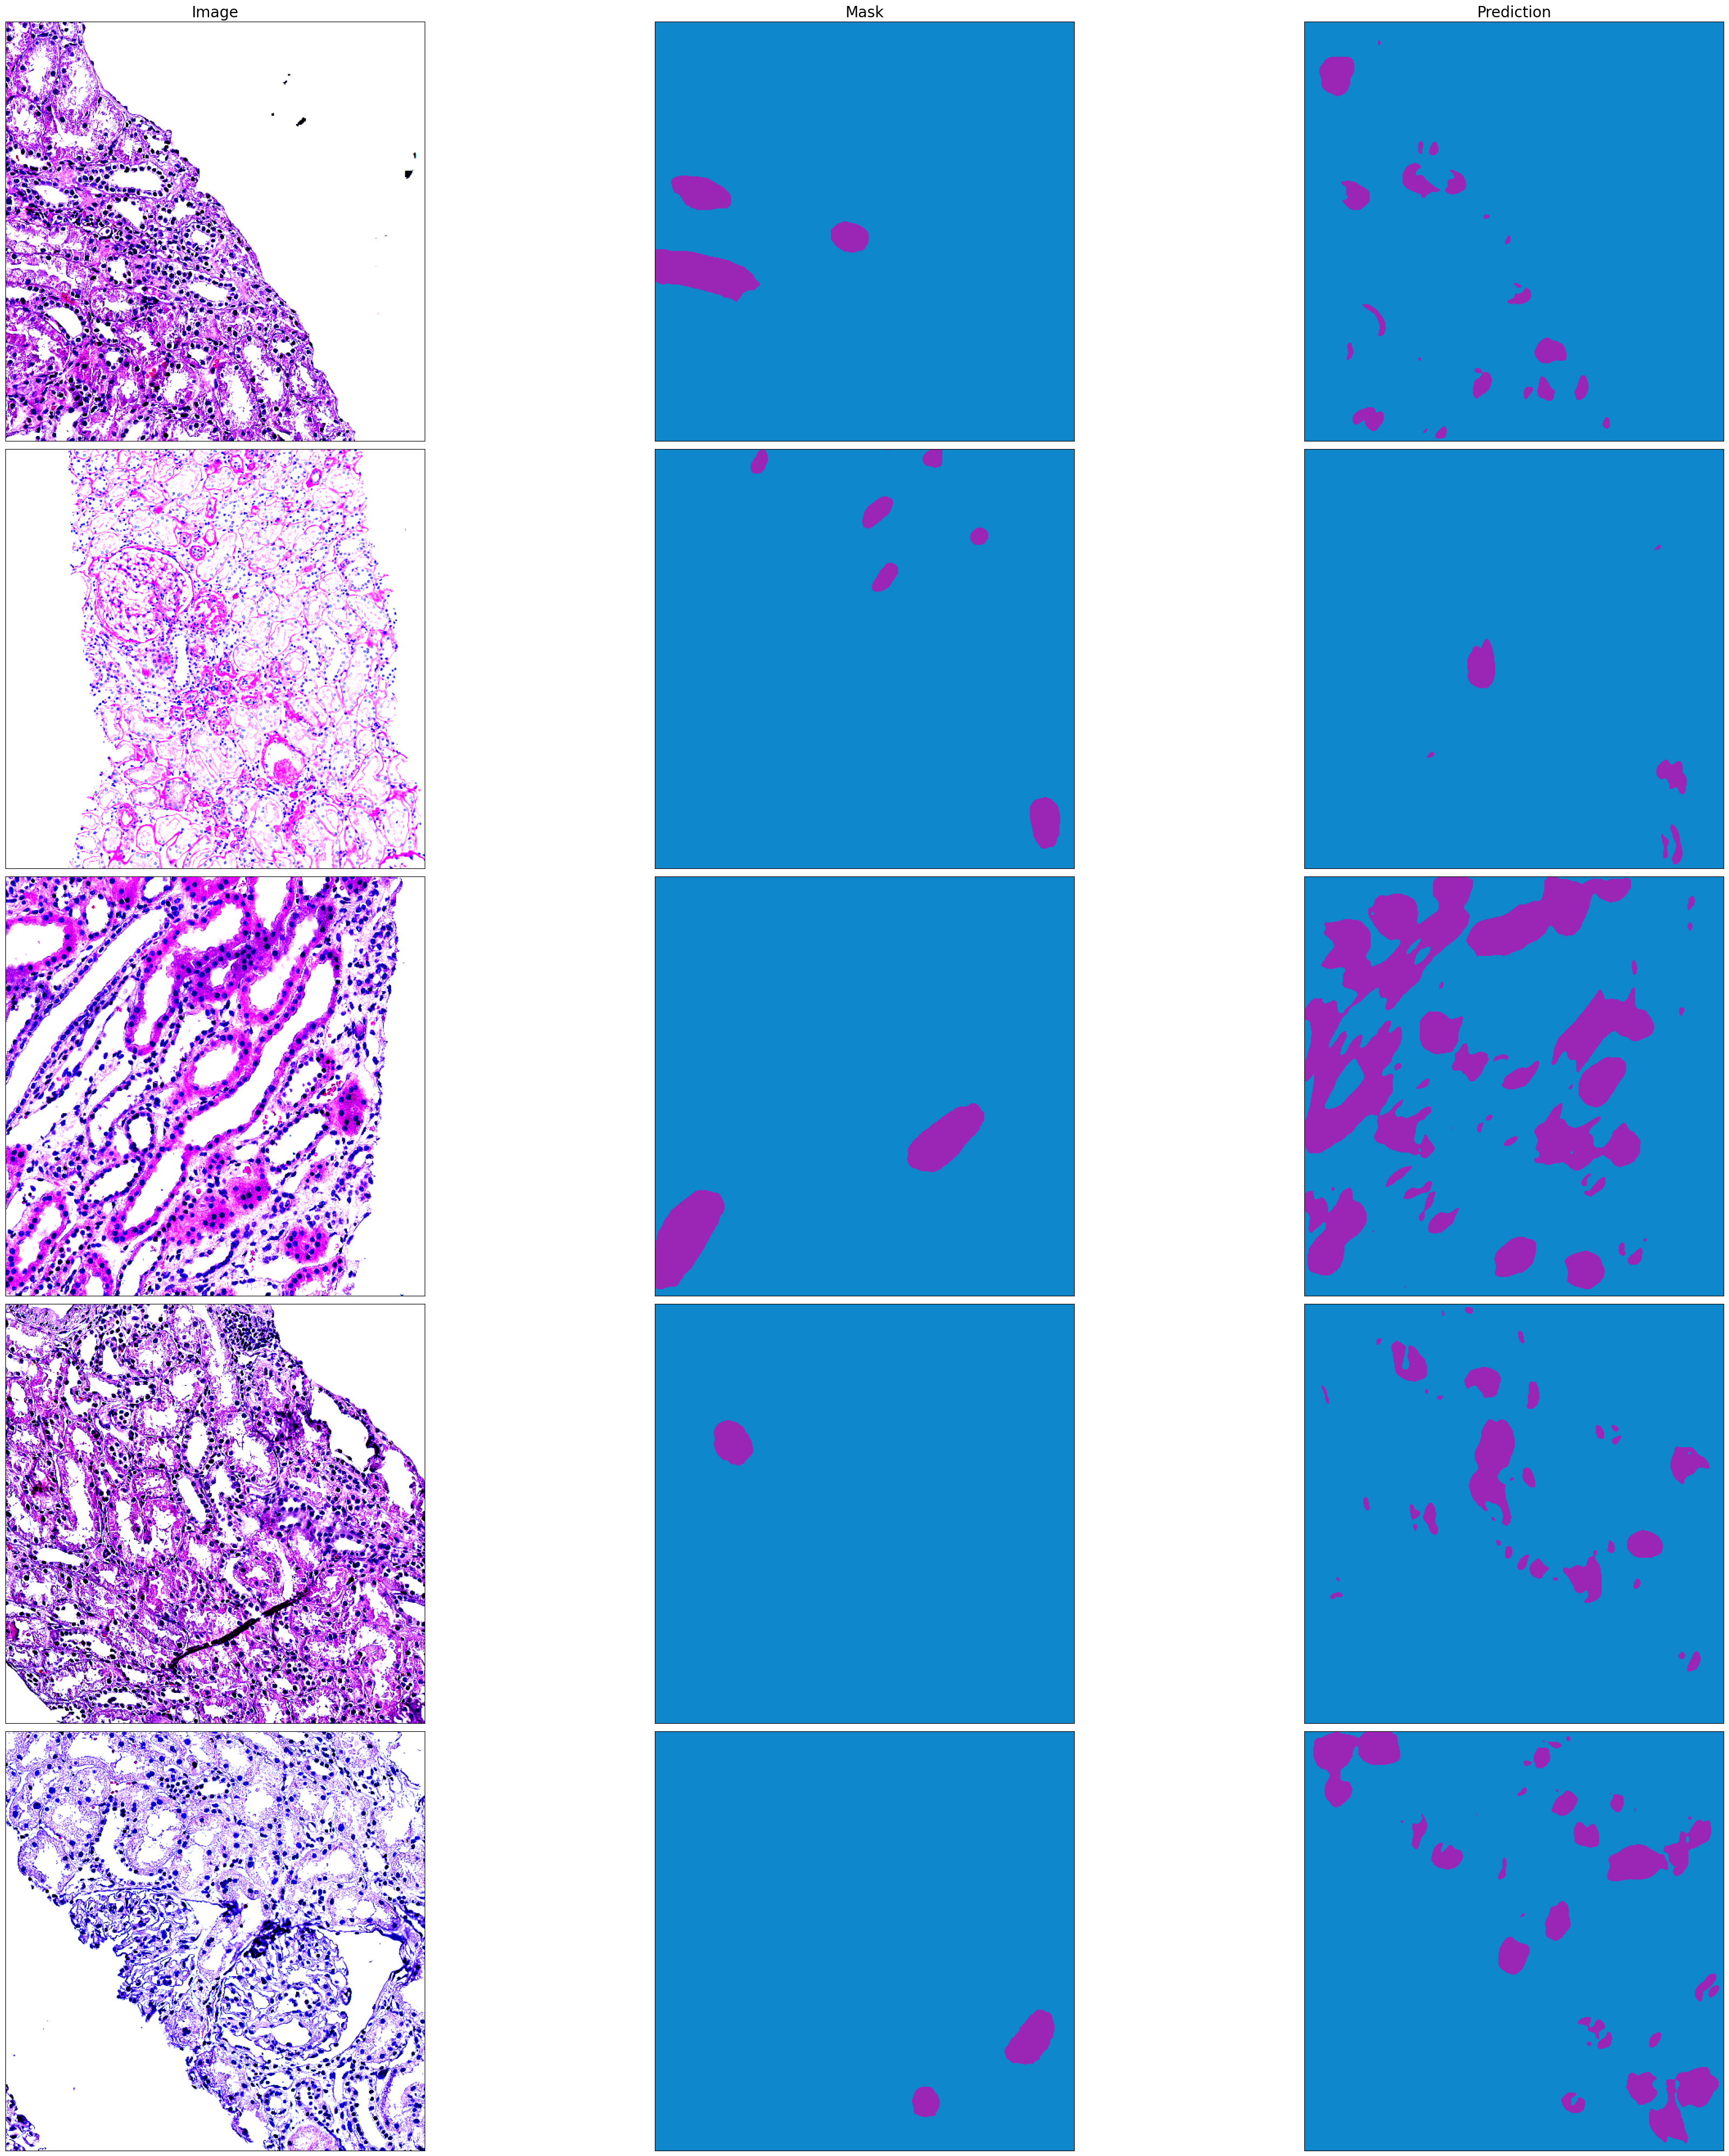

In [22]:
import random
random.seed(10)
samples = random.sample(range(len(test_dataset)), 5)

palette = [[155,38,182], [14,135,204], [124,252,0], [255,20,147], [169,169,169]]
pal = [value for color in palette for value in color]

cols = ['Image', 'Mask', 'Prediction']
fig, axes = plt.subplots(len(samples), 3, figsize=(60, 40), sharex='row', sharey='row', 
                         subplot_kw={'xticks':[], 'yticks':[]}, tight_layout=True)

for ax, col in zip(axes[0], cols): ax.set_title(col, fontsize=20) # set column label --> considered epoch
    
for i in range(len(samples)):
        image, mask = test_dataset[samples[i]]
        print(np.unique(mask))
        pred = torch.argmax(model(torch.tensor(image).unsqueeze(0).to(device)), 1)

        mask = Image.fromarray(mask.squeeze(0).astype('uint8')).convert('P')
        pred = Image.fromarray(np.array(pred.squeeze(0).cpu()).astype('uint8')).convert('P')
        mask.putpalette(pal)
        pred.putpalette(pal)

        axes[i, 0].imshow(np.array(image).transpose(1, 2, 0));
        axes[i, 1].imshow(mask);
        axes[i, 2].imshow(pred);
        
fig.savefig(arch + '.png')

In [25]:
metrics = np.round(torch.stack([torch.mean(smp.metrics.recall(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.accuracy(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.false_positive_rate(tp, fp, fn, tn, reduction=None), 0),
                                1 - torch.mean(smp.metrics.recall(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.precision(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.iou_score(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.f1_score(tp, fp, fn, tn, reduction=None), 0),

                                ]).cpu().numpy(), 3)

info = {'Recall': metrics[0],
        'Accuracy':metrics[1],
        'Precision': metrics[4],
        'IoU': metrics[5],
        'F1-Score': metrics[6]
        }

table = tabulate(info, headers='keys', tablefmt='fancy_grid')
print(table)

with open(f'{arch}.txt', 'w') as f:
    f.write(table)

╒══════════╤════════════╤═════════════╤═══════╤════════════╕
│   Recall │   Accuracy │   Precision │   IoU │   F1-Score │
╞══════════╪════════════╪═════════════╪═══════╪════════════╡
│    0.191 │      0.918 │       0.072 │ 0.041 │      0.073 │
├──────────┼────────────┼─────────────┼───────┼────────────┤
│    0.928 │      0.918 │       0.987 │ 0.917 │      0.956 │
╘══════════╧════════════╧═════════════╧═══════╧════════════╛
